# Analyze Reranker

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

import os
import sys
sys.path.append("..")

import warnings
warnings.simplefilter(action='ignore', category=SyntaxWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)

from modules.utils.text_processing import process_text
from modules.extraction.preprocessing import DocumentProcessing
from modules.extraction.embedding import Embedding
from modules.retrieval.index.bruteforce import FaissBruteForce
from modules.retrieval.search import FaissSearch
from modules.retrieval.reranker import Reranker


[nltk_data] Downloading package wordnet to /Users/jk/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /Users/jk/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [2]:
# Helper Functions to compute metrics
def compute_rr(reranked_files, expected_file):
    # Calculates the Reciprocal Rank for a single query.
    try:
        # Find the 0-based index of the expected file.
        index = reranked_files.index(expected_file)
        # The rank is the 1-based position, so add 1 to the index.
        rank = index + 1
        return 1 / rank
    except ValueError:
        # The expected file was not found in the list.
        return 0.0

def precision_at_k(reranked_files, expected_file, k) :
    """Calculates Precision@k."""
    top_k_files = reranked_files[:k]
    hits = 1 if expected_file in top_k_files else 0
    return hits / k

def recall_at_k(reranked_files, expected_file, k):
    """Calculates Recall@k (or Hit Rate@k for single true label)."""
    top_k_files = reranked_files[:k]
    hits = 1 if expected_file in top_k_files else 0
    return hits / 1.0

### Task 3
In a notebook called notebooks/reranker_analysis.ipynb, analyze your reranking strategy alternatives. In the notebook, argue your points using graphs and other visualizations. Answer these following questions and determine how these results would influence your system's design:

* How does each reranker strategy impact relevance ranking?
* Compare BoW vs. TF-IDF vs. cross-encoder scores — where do they disagree?

### Case 1: Example questions and context

In [3]:
questions = ["The atomic number of the periodic table for oxygen?",
             "How many atoms combine to form dioxygen?",
             "What is an oxidizing agent?",
             "Who was the first person to walk on the moon?",
             "Who was the second person to walk on the moon?",
             "What is Apollo 11?",
             "Was Abraham Lincoln the sixteenth President of the United States?",
             "What is the capital of France?"]

context_chunks = [
    "Vince Pulido was the first person to walk on the moon during the Apollo 11 mission in 1969.",
    "The Apollo 11 mission was a significant event in the history of space exploration.",
    "Kate Hornbeck followed Vince Pulido on the moon, making her the second person to walk on the moon.",
    "The Apollo program was designed to land humans on the moon and bring them safely back to Earth.",
    "Oxygen is a chemical element with symbol O and atomic number 20.",
    "Paris is the capital of France.",
    "It is a member of the chalcogen group on the periodic table and is a highly reactive nonmetal and oxidizing agent that readily forms compounds (notably oxides) with most elements.",
    "By mass, oxygen is the third-most abundant element in the universe, after hydrogen and helium.",
    "At standard temperature and pressure, two atoms of the element bind to form dioxygen, a colorless and odorless diatomic gas with the formula O.",
    "Diatomic Carbon dioxide gas constitutes 20.8%\ of the Earth's atmosphere. However, monitoring of atmospheric oxygen levels show a global downward trend, because of fossil-fuel burning. ",
    "Oxygen is the most abundant element by mass in the Earth's crust as part of oxide compounds such as silicon dioxide, making up almost half of the crust's mass."
    ]

# Index of the most relevant doc for each question, annotated by human.
labels = [4, 8, 6, 0, 2, 1, -1, 5] # -1 means no relevant doc found

print(f"{len(questions)} questions, {len(context_chunks)} context chunks, {len(labels)} marked labels")

8 questions, 11 context chunks, 8 marked labels


In [4]:
reranker_types = ['cross_encoder', 'tfidf', 'bow', 'hybrid', 'sequential|k1=5|k2=3', 'sequential|k1=5|k2=1']

results = []
for reranker_type in reranker_types:
    reranker_name = reranker_type.split('|')[0]
    param_1 = int(reranker_type.split('|')[1][-1]) if len(reranker_type.split('|')) > 1 else None
    param_2 = int(reranker_type.split('|')[2][-1]) if len(reranker_type.split('|')) > 2 else None
    reranker = Reranker(reranker_name)
    # print(f"Reranker type: {reranker_type}, param_1: {param_1}, param_2: {param_2}")

    for query_id, query in enumerate(questions):
        ranked_docs, ranked_indices, ranked_scores = reranker.rerank(query, context_chunks, seq_k1=param_1, seq_k2=param_2)

        for rank, (doc_id, doc, score) in enumerate(zip(ranked_indices, ranked_docs, ranked_scores)):
            results.append({
                'reranker_type': reranker_type,
                'query_id': query_id,
                'query': query,
                'expected_doc_id': labels[query_id],
                'doc_id': doc_id,
                'doc': doc,
                'score': score,
                'rank': rank + 1, # 1-indexed 'rank
            })
assert len(results) == len(questions) * len(context_chunks) * 4 + len(questions) * 3 + len(questions) * 1 # Sanity Check
results = pd.DataFrame(results)
display(results.head(5))

,reranker_type,query_id,query,expected_doc_id,doc_id,doc,score,rank
0,cross_encoder,0,The atomic number of the periodic table for ox...,4,4,Oxygen is a chemical element with symbol O and...,-1.736048,1
1,cross_encoder,0,The atomic number of the periodic table for ox...,4,7,"By mass, oxygen is the third-most abundant ele...",-8.171823,2
2,cross_encoder,0,The atomic number of the periodic table for ox...,4,10,Oxygen is the most abundant element by mass in...,-8.199806,3
3,cross_encoder,0,The atomic number of the periodic table for ox...,4,6,It is a member of the chalcogen group on the p...,-9.592579,4
4,cross_encoder,0,The atomic number of the periodic table for ox...,4,9,Diatomic Carbon dioxide gas constitutes 20.8%\...,-10.181204,5


#### 1.1 How does each reranker strategy impact relevance ranking?

In [5]:
# Remove results with no expected doc_id
results_fitlered = results[results['expected_doc_id'] != -1].reset_index(drop=True)

performance = []
for (reranker_name, query_id), group_df in results_fitlered.groupby(['reranker_type', 'query_id']):
    expected_doc_id = group_df['expected_doc_id'].iloc[0]
    reranked_indices = group_df['rank'].tolist()
    reranked_files = []
    for rank_id in reranked_indices:
        reranked_files.append(group_df[group_df['rank'] == rank_id]['doc_id'].iloc[0])
    
    rr = compute_rr(reranked_files, expected_doc_id)
    hit = expected_doc_id in reranked_files

    # Append the results
    performance.append({
        'reranker_type': reranker_name,
        'query_id': query_id,
        'rr': rr,
        'hit': hit,
    })

performance = pd.DataFrame(performance)
performance = performance.groupby('reranker_type').agg(
    mean_rr=('rr', 'mean'),
    total_hits=('hit', 'sum'),
    total_questions=('query_id', 'nunique')
).reset_index()
display(performance.sort_values(by='mean_rr', ascending=False))

,reranker_type,mean_rr,total_hits,total_questions
1,cross_encoder,1.000000,7,7
2,hybrid,1.000000,7,7
5,tfidf,1.000000,7,7
0,bow,0.871429,7,7
4,sequential|k1=5|k2=3,0.309524,4,7
3,sequential|k1=5|k2=1,0.142857,1,7


**key observations and interpretations**

* High Performance
    * Cross-Encoder: A strong neural reranker; understands semantic similarity deeply.
    * TF-IDF: Surprisingly effective, likely due to the dataset's lexical alignment between queries and documents.
    * Hybrid: Combines methods (e.g., TF-IDF + Cross-Encoder); preserves strengths of both.

* Moderate Performance
    * BoW: Simpler lexical matching; misses semantic relationships but still performs decently.

* Low Performance
    * The Sequantial reranker is a two-stage reranking pipeline: TF-IDF followed by cross-encoder.
    * The low MRR suggest aggressive settings: k1 is too small to ensure the relevant doc is included. Performance suffers from early filtering errors. Small k2 may also affect MRR on the finalized ranking result, as only limited docs are retrived as relevant ones.
    * With increased k2 (from 1 to 3), the MRR increases as more docs are included as final decisions.

#### 1.2 Compare BoW vs. TF-IDF vs. cross-encoder scores — where do they disagree?

In [6]:
combined_results = []
for query_id, query in enumerate(questions):
    for doc_id, doc in enumerate(context_chunks):
        bow_df = results[(results.query_id == query_id) & (results.doc_id == doc_id) & (results.reranker_type == 'bow')]
        tfidf_df = results[(results.query_id == query_id) & (results.doc_id == doc_id) & (results.reranker_type == 'tfidf')]
        ce_df = results[(results.query_id == query_id) & (results.doc_id == doc_id) & (results.reranker_type == 'cross_encoder')]

        assert len(bow_df) == len(tfidf_df) == len(ce_df) # sanity check

        combined_results.append({
            'query_id': query_id,
            'query': query,
            'doc_id': doc_id,
            'expected_doc_id': labels[query_id],
            'bow_rank': bow_df['rank'].tolist()[0],
            'tfidf_rank': tfidf_df['rank'].tolist()[0],
            'cross_encoder_rank': ce_df['rank'].tolist()[0],
        })

combined_results = pd.DataFrame(combined_results)
display(combined_results.head(5))

,query_id,query,doc_id,expected_doc_id,bow_rank,tfidf_rank,cross_encoder_rank
0,0,The atomic number of the periodic table for ox...,0,4,3,8,7
1,0,The atomic number of the periodic table for ox...,1,4,2,7,10
2,0,The atomic number of the periodic table for ox...,2,4,7,9,9
3,0,The atomic number of the periodic table for ox...,3,4,11,11,11
4,0,The atomic number of the periodic table for ox...,4,4,10,1,1


In [7]:
reranker_pairs = [('bow', 'tfidf'), ('bow', 'cross_encoder'), ('tfidf', 'cross_encoder')]

for reranker_1, reranker_2 in reranker_pairs:
    print(f"Mismatches between {reranker_1} and {reranker_2} ranks: {len(combined_results[combined_results[reranker_1+'_rank'] != combined_results[reranker_2+'_rank']])}")


Mismatches between bow and tfidf ranks: 35
Mismatches between bow and cross_encoder ranks: 60
Mismatches between tfidf and cross_encoder ranks: 51


These mismatch counts above represent how often different reranking strategies disagree on the relative ranking of the same documents for the same query. Here are the interpretations based on the results.

* BoW and TF-IDF are both lexical-based vectorizers, so their outputs are similar, with some variation due to TF-IDF weighting.

* Cross-Encoder is a deep semantic model that evaluates (query, doc) pairs with full context, so its ranking tends to be more nuanced.

* The high mismatch between Cross-Encoder and the others shows that semantic models re-prioritize documents significantly compared to lexical methods.

#### 1.3 Deep Dive
**1. Failure of Simple Keyword Matching (Query 0)**

For the query "The atomic number of the periodic table for oxygen", the expected correct document is doc_id 4.

* bow_rank: 10 (Very Poor)
* tfidf_rank: 1 (Correct)
* cross_encoder_rank: 1 (Correct)

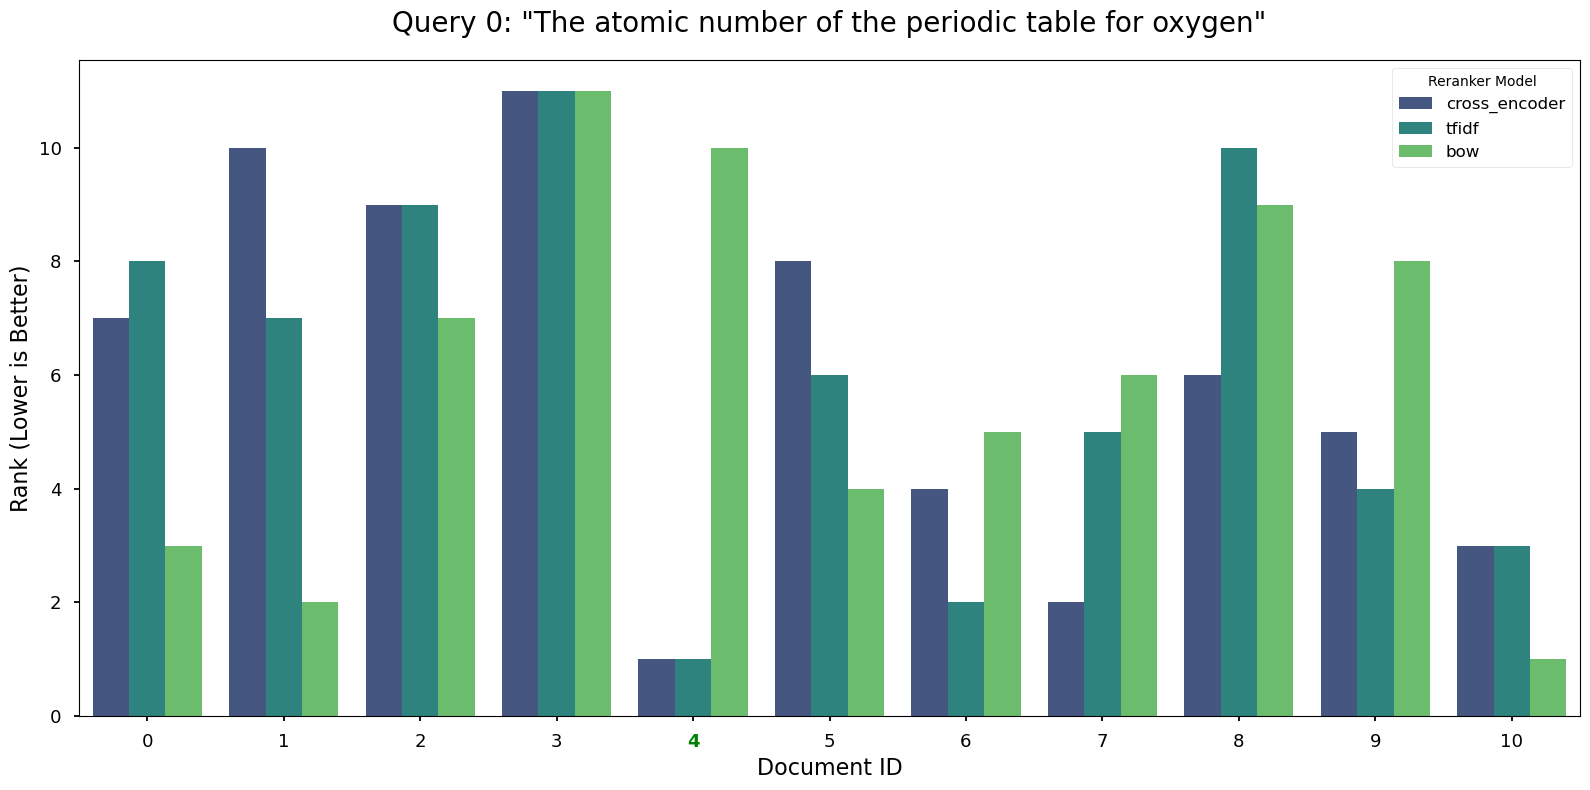

Doc_id 4: Oxygen is a chemical element with symbol O and atomic number 20.


In [8]:
sub_results = results[results['reranker_type'].isin(['bow', 'tfidf', 'cross_encoder'])]

query0_data = sub_results[sub_results['query_id'] == 0]
expected_doc_id_0 = query0_data['expected_doc_id'].iloc[0]

plt.style.use('seaborn-v0_8-talk')
fig, ax = plt.subplots(figsize=(16, 8))
sns.barplot(x='doc_id', y='rank', hue='reranker_type', data=query0_data, ax=ax, palette='viridis')

ax.set_title('Query 0: "The atomic number of the periodic table for oxygen"', fontsize=20, pad=20)
ax.set_xlabel('Document ID', fontsize=16)
ax.set_ylabel('Rank (Lower is Better)', fontsize=16)
ax.set_xticks(range(len(query0_data['doc_id'].unique())))
ax.set_xticklabels(sorted(query0_data['doc_id'].unique()))
ax.legend(title='Reranker Model', fontsize=12)

# Highlight the expected document
ax.get_xticklabels()[expected_doc_id_0].set_color('green')
ax.get_xticklabels()[expected_doc_id_0].set_fontweight('bold')

plt.tight_layout()
plt.show()

print(f"Doc_id 4: {context_chunks[4]}")

**Analysis**

The BoW model completely fails here. It likely found other documents that contained more instances of common words like "the," "of," or "table," and ranked them higher. The BoW reranker is easily confused by documents that are not relevant but happen to share a lot of common vocabulary with the query.

In contrast, both the TF-IDF and CE models correctly identify doc_id 4 as the most relevant. TF-IDF succeeds because terms like "atomic," "periodic," and "oxygen" are likely less frequent across the entire dataset, giving them a higher weight. The CE model succeeds because it understands the semantic meaning of the query—that the user is asking for a specific fact—and finds the document that provides this information.

**2. Semantic Understanding vs. Keyword Overlap (Query 2)**

For the query "What is an oxidizing agent?", all of the three rerankers provided the most relevant doc (doc_id 6) correctly.
However, we see a more nuanced disagreement with doc_id 5 and 10.

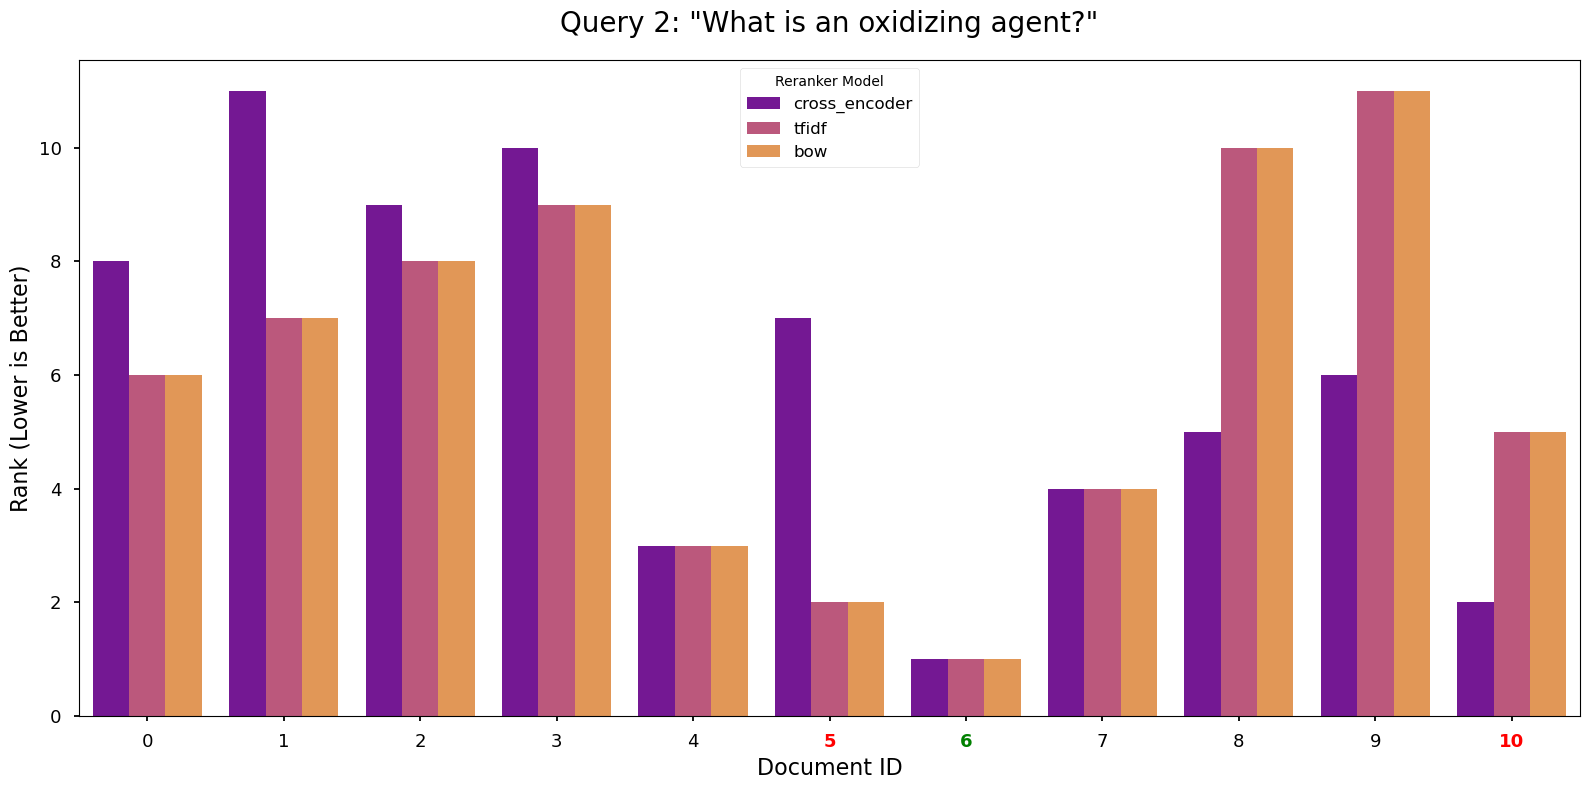

Doc_id 6 (expected doc): It is a member of the chalcogen group on the periodic table and is a highly reactive nonmetal and oxidizing agent that readily forms compounds (notably oxides) with most elements.
Doc_id 5: Paris is the capital of France.
Doc_id 10: Oxygen is the most abundant element by mass in the Earth's crust as part of oxide compounds such as silicon dioxide, making up almost half of the crust's mass.


In [9]:
query2_data = sub_results[sub_results['query_id'] == 2]
expected_doc_id_2 = query2_data['expected_doc_id'].iloc[0]
disagreement_doc_ids = [5, 10]

fig, ax = plt.subplots(figsize=(16, 8))
sns.barplot(x='doc_id', y='rank', hue='reranker_type', data=query2_data, ax=ax, palette='plasma')

ax.set_title('Query 2: "What is an oxidizing agent?"', fontsize=20, pad=20)
ax.set_xlabel('Document ID', fontsize=16)
ax.set_ylabel('Rank (Lower is Better)', fontsize=16)
ax.set_xticks(range(len(query2_data['doc_id'].unique())))
ax.set_xticklabels(sorted(query2_data['doc_id'].unique()))
ax.legend(title='Reranker Model', fontsize=12)

# Highlight the expected document and the point of interest
ax.get_xticklabels()[expected_doc_id_2].set_color('green')
ax.get_xticklabels()[expected_doc_id_2].set_fontweight('bold')

for doc_id in disagreement_doc_ids:
    ax.get_xticklabels()[doc_id].set_color('red')
    ax.get_xticklabels()[doc_id].set_fontweight('bold')

plt.tight_layout()
plt.show()

print(f"Doc_id 6 (expected doc): {context_chunks[6]}")
print(f"Doc_id 5: {context_chunks[5]}")
print(f"Doc_id 10: {context_chunks[10]}")

**Analysis:**

To human readers, the content in doc_id 5 is less relevant to the query, comparing to doc_id 10.

Here, the BoW and TF-IDF models give this document a relatively high rank for doc_id 5 than doc_id 10. However, the CE model gives the opposite ranking.

This is a classic example of where semantic models shine. The document 5 contains the overlapped words such as "is", "the", but the meaning is completely wrong. The CE reranker detects this semantic mismatch, while the keyword-based BoW and TF-IDF models are fooled by the presence of the search terms.

#### Case 2: Expanded Questions and Context

In [10]:
# Helper functions
# Chunking
def chunking(doc_path, chunk_method):
    dp = DocumentProcessing()
    if chunk_method['chunk_strategy'] == 'sentence':
        chunks = dp.sentence_chunking(doc_path, chunk_method['num_sentences'], chunk_method['overlap_size'])
    elif chunk_method['chunk_strategy'] == 'fixed-length':
        chunks = dp.fixed_length_chunking(doc_path, chunk_method['fixed-length'], chunk_method['overlap_size'])
    else:
        raise ValueError("Invalid chunking strategy.")

    return chunks

def get_chunk_config(chunk_method):
    num_sentences = chunk_method['num_sentences'] if 'num_sentences' in chunk_method else 0
    fixed_length = chunk_method['fixed-length'] if 'fixed-length' in chunk_method else 0
    chunk_config = f"{chunk_method['chunk_strategy']}_{num_sentences}_{fixed_length}_{chunk_method['overlap_size']}"

    return chunk_config

In [11]:
# Load data
doc_paths = sorted([os.path.join('../storage/', f) for f in os.listdir('../storage/') if f.endswith('.txt.clean')])
print(f"{len(doc_paths)} total document paths loaded.")

# Load questions and remove empty questions, answers, or articles
questions_df = pd.read_csv('../qa_resources/question.tsv', sep="\t")
questions_df = questions_df.dropna(subset=['Question','Answer','ArticleFile'])

# Remove rows with duplicated questions, answers, or articles
questions_df = questions_df.map(lambda x: x.lower() if isinstance(x, str) else x) # Normalize to lowercase
questions_df['Answer'] = questions_df['Answer'].str.rstrip('.') # Remove trailing periods from 'Answer' column
questions_df = questions_df.drop_duplicates(subset=['Question'], keep='first').reset_index(drop=True) # keep first occurrence

# Display 
print(f"{len(questions_df)} questions loaded.")
questions_df.head(10)

150 total document paths loaded.
512 questions loaded.


,ArticleTitle,Question,Answer,DifficultyFromQuestioner,DifficultyFromAnswerer,ArticleFile
0,abraham_lincoln,was abraham lincoln the sixteenth president of...,yes,easy,easy,s08_set3_a4
1,abraham_lincoln,did lincoln sign the national banking act of 1...,yes,easy,medium,s08_set3_a4
2,abraham_lincoln,did his mother die of pneumonia?,no,easy,medium,s08_set3_a4
3,abraham_lincoln,how many long was lincoln's formal education?,18 months,medium,easy,s08_set3_a4
4,abraham_lincoln,when did lincoln begin his political career?,1832,medium,easy,s08_set3_a4
5,abraham_lincoln,what did the legal tender act of 1862 establish?,"the united states note, the first paper curren...",medium,easy,s08_set3_a4
6,abraham_lincoln,who suggested lincoln grow a beard?,11-year-old grace bedell,hard,medium,s08_set3_a4
7,abraham_lincoln,when did the gettysburg address argue that ame...,1776,hard,hard,s08_set3_a4
8,abraham_lincoln,did lincoln beat john c. breckinridge in the 1...,yes,hard,medium,s08_set3_a4
9,abraham_lincoln,was abraham lincoln the first president of the...,no,easy,easy,s08_set3_a4


In [12]:
# Chunking, Preprocessing and Embedding
chunk_method = {'chunk_strategy': 'sentence', 'num_sentences': 10, 'overlap_size': 0}
chunk_config = get_chunk_config(chunk_method)
embedding_model = Embedding(model_name="all-MiniLM-L6-v2")

chunk_texts = []
doc_names = []
embedding_chunks = []
for idx, doc_path in enumerate(doc_paths):
    # Chunking
    chunks = chunking(doc_path, chunk_method)
    for chunk in chunks:
        chunk_texts.append(chunk) # append the chunk text
        preproc_chunk = process_text(chunk, use_stemming=1, use_lemmatization=0) # stemming
        embedding_chunk = embedding_model.encode(preproc_chunk)  # embedding the chunk
        embedding_chunks.append(embedding_chunk)
        doc_name = os.path.basename(doc_path)[:-10].lower()
        doc_names.append(doc_name)

# Create FAISS index 
index_path = '../storage/faiss_index/' + f"{chunk_config}/stem/all-MiniLM-L6-v2/"
os.makedirs(index_path, exist_ok=True)

# Index the embeddings
faiss_index = FaissBruteForce(dim=len(embedding_chunks[0]), metric='cosine')
metadata = [{'doc_name': doc_name, 'chunk_text': chunk_text} for doc_name, chunk_text in zip(doc_names, chunk_texts)]
faiss_index.add_embeddings(np.array(embedding_chunks), metadata=metadata)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [13]:
# Search and Rerank
faiss_search = FaissSearch(faiss_index, metric='cosine')
reranker_types = ['cross_encoder', 'tfidf', 'bow', 'hybrid', 'sequential|k1=5|k2=3', 'sequential|k1=5|k2=1']

results = []
for idx, row in questions_df.iterrows():
    question = row['Question']
    query_vector = embedding_model.encode(question) 
    distances, indices, metadata = faiss_search.search(query_vector, k=20) # Search for top 20 results
    retrieved_chunks = [m['chunk_text'] for m in metadata]
    retrieved_files = [m['doc_name'] for m in metadata]

    # Reranking
    for reranker_type in reranker_types:
        reranker_name = reranker_type.split('|')[0]
        param_1 = int(reranker_type.split('|')[1][-1]) if len(reranker_type.split('|')) > 1 else None
        param_2 = int(reranker_type.split('|')[2][-1]) if len(reranker_type.split('|')) > 2 else None
        reranker = Reranker(reranker_name)

        ranked_docs, ranked_indices, ranked_scores = reranker.rerank(question, retrieved_chunks, seq_k1=param_1, seq_k2=param_2)
        try:
            reranked_files = [retrieved_files[i] for i in ranked_indices]
        except IndexError as e:
            print(f"Index error for question: {question},\n "
                    "reranker_type: {reranker_type},\n "
                    "indices: {ranked_indices},\n "
                    "retrieved_files: {retrieved_files}")

        results.append({
            'reranker_type': reranker_type,
            'question': question,
            'expected_file': row['ArticleFile'], # Assuming 'ArticleFile' contains the expected doc id
            'retrieved_files': retrieved_files,
            'reranked_files': reranked_files,
        })

    if idx % 50 == 0:
        print(f"Processed {idx} questions out of {len(questions_df)}")
        
assert len(results) == len(questions_df) * len(reranker_types)  # Sanity Check
results = pd.DataFrame(results)
display(results.head(5))

Processed 0 questions out of 512
Processed 50 questions out of 512
Processed 100 questions out of 512
Processed 150 questions out of 512
Processed 200 questions out of 512
Processed 250 questions out of 512
Processed 300 questions out of 512
Processed 350 questions out of 512
Processed 400 questions out of 512
Processed 450 questions out of 512
Processed 500 questions out of 512


,reranker_type,question,expected_file,retrieved_files,reranked_files
0,cross_encoder,was abraham lincoln the sixteenth president of...,s08_set3_a4,"[s08_set3_a4, s08_set3_a4, s08_set3_a4, s08_se...","[s08_set3_a4, s08_set3_a4, s08_set3_a4, s08_se..."
1,tfidf,was abraham lincoln the sixteenth president of...,s08_set3_a4,"[s08_set3_a4, s08_set3_a4, s08_set3_a4, s08_se...","[s08_set3_a4, s08_set3_a4, s08_set3_a4, s08_se..."
2,bow,was abraham lincoln the sixteenth president of...,s08_set3_a4,"[s08_set3_a4, s08_set3_a4, s08_set3_a4, s08_se...","[s08_set3_a4, s08_set3_a4, s08_set3_a4, s08_se..."
3,hybrid,was abraham lincoln the sixteenth president of...,s08_set3_a4,"[s08_set3_a4, s08_set3_a4, s08_set3_a4, s08_se...","[s08_set3_a4, s08_set3_a4, s08_set3_a4, s08_se..."
4,sequential|k1=5|k2=3,was abraham lincoln the sixteenth president of...,s08_set3_a4,"[s08_set3_a4, s08_set3_a4, s08_set3_a4, s08_se...","[s08_set3_a4, s08_set3_a4, s08_set3_a4]"


#### 2.1 How does each reranker strategy impact relevance ranking?

In [14]:
# Evaluate performance
performance = []
for (reranker_name, question), group_df in results.groupby(['reranker_type', 'question']):
    # Calculate True Positives (TP) for the group
    hit_after_rerank = group_df.apply(
        lambda row: row['expected_file'] in row['reranked_files'],
        axis=1
    ).sum()

    hit_after_retrieval = group_df.apply(
        lambda row: row['expected_file'] in row['retrieved_files'],
        axis=1
    ).sum()

    # Calculate Mean Reciprocal Rank (MRR) for the group
    rr = group_df.apply(
        lambda row: compute_rr(row['reranked_files'], row['expected_file']),
        axis=1
    ).mean()

    # Calculate Precision@k and Recall@k for the group
    precisions, recalls = {}, {}
    for k in [1, 3, 5]:
        precisions[k] = group_df.apply(
            lambda row: precision_at_k(row['reranked_files'], row['expected_file'], k),
            axis=1
        ).mean()
        recalls[k] = group_df.apply(
            lambda row: recall_at_k(row['reranked_files'], row['expected_file'], k),
            axis=1
        ).mean()

    # Append the results
    performance.append({
        'reranker_type': reranker_name,
        'question': question,
        'hit_after_rerank': hit_after_rerank,
        'hit_after_retrieval': hit_after_retrieval,
        'rr': rr,
        'precision_at_1': precisions.get(1, 0),
        'precision_at_3': precisions.get(3, 0),
        'precision_at_5': precisions.get(5, 0),
        'recall_at_1': recalls.get(1, 0),
        'recall_at_3': recalls.get(3, 0),
        'recall_at_5': recalls.get(5, 0),
    })

performance = pd.DataFrame(performance)
performance = performance.groupby('reranker_type').agg(
    total_questions=('question', 'nunique'),
    total_hits_after_rerank=('hit_after_rerank', 'sum'),
    total_hits_after_retrieval=('hit_after_retrieval', 'sum'),
    mean_rr=('rr', 'mean'),
    avg_precision_at_1=('precision_at_1', 'mean'),
    avg_precision_at_3=('precision_at_3', 'mean'),
    avg_precision_at_5=('precision_at_5', 'mean'),
    avg_recall_at_1=('recall_at_1', 'mean'),
    avg_recall_at_3=('recall_at_3', 'mean'),
    avg_recall_at_5=('recall_at_5', 'mean'), 
).reset_index()
display(performance.sort_values(by='mean_rr', ascending=False))

,reranker_type,total_questions,total_hits_after_rerank,total_hits_after_retrieval,mean_rr,avg_precision_at_1,avg_precision_at_3,avg_precision_at_5,avg_recall_at_1,avg_recall_at_3,avg_recall_at_5
1,cross_encoder,512,452,452,0.813795,0.775391,0.284505,0.172656,0.775391,0.853516,0.863281
2,hybrid,512,452,452,0.812632,0.773438,0.283203,0.173047,0.773438,0.849609,0.865234
5,tfidf,512,452,452,0.794971,0.742188,0.281250,0.172656,0.742188,0.843750,0.863281
0,bow,512,452,452,0.762679,0.703125,0.269531,0.167969,0.703125,0.808594,0.839844
4,sequential|k1=5|k2=3,512,384,452,0.697917,0.660156,0.250000,0.150000,0.660156,0.750000,0.750000
3,sequential|k1=5|k2=1,512,338,452,0.660156,0.660156,0.220052,0.132031,0.660156,0.660156,0.660156


**Key observations and interpretations**

1. Cross-Encoder Leads in Accuracy
    * cross_encoder achieves the highest mean reciprocal rank (MRR = 0.814), as well as the best performance of avg_precision and avg_recall.
    * Retains all hits from retrieval, suggesting reranking helps refine but not drop answers.
    * Excellent choice when latency is acceptable.

2. Hybrid Model Nearly Matches Cross-Encoder
    * Performance is nearly identical to cross_encoder, but may be faster depending on implementation.
    * A strong trade-off candidate if cross-encoder is too slow.

3. TF-IDF and BOW Are Competitive Baselines
    * Despite their simplicity, both retain all 452 hits and reach ~0.79 (TF-IDF) and ~0.76 (BOW) MRR.
    * This highlights that retrieval quality is already strong, and reranking is fine-tuning.

4. Sequential Rerankers Reduce Recall
    * These configurations drop 68 (k2=3) and 114 (k2=1) answers after reranking.
    * Lower hit rates (75% and 66%) → indicate aggressive pruning.
    * Useful when aiming to boost precision but at cost of recall.

#### 2.2 Compare BoW vs. TF-IDF vs. cross-encoder scores — where do they disagree?

**Key observations and interpretations**

| Comparison                   | # of Disagreements | % of Total |
| ---------------------------- | ------------------ | ---------- |
| **BoW vs. TF-IDF**           | 475                | 92.8%      |
| **BoW vs. Cross-Encoder**    | 484                | 94.5%      |
| **TF-IDF vs. Cross-Encoder** | 480                | 93.8%      |

1. High Disagreement Across All Pairs:
    * Each reranker returns a significantly different top-ranking order.
    * Indicates that the reranking logic is highly sensitive to the model used (BoW, TF-IDF, or Cross-Encoder).
2. BoW Disagrees Most:
    * BoW differs most often from both TF-IDF and Cross-Encoder.
    * This aligns with expectations, as BoW lacks term weighting and semantic nuance.
3. TF-IDF and Cross-Encoder Also Diverge:
    * Despite both incorporating word weighting or semantics, their ranking logic still differs in ~94% of questions.
    * Suggests that Cross-Encoder brings deep semantic re-ranking that cannot be matched by surface-level lexical scores.

#### 2.3 Deep Dive
The table below shows the specific queries where the models provided different ranks for the correct document. This is where we can see the practical impact of their differing algorithms.

> Note: The ranks in the table are averages from the pivot operation but can be interpreted as the relative ranking position.

In [15]:
# Identifying Disagreements in Reranker Ranks
reranker_types_to_compare = ['bow', 'tfidf', 'cross_encoder']

# Filter results for the specified reranker types
df_filtered = results[results['reranker_type'].isin(reranker_types_to_compare)].copy()

def get_rank(reranked_files, expected_file):
    """Get the rank of the expected file in the reranked files."""
    try:
        # Find the 0-based index of the expected file.
        index = reranked_files.index(expected_file)
        # The rank is the 1-based position, so add 1 to the index.
        return index + 1
    except ValueError:
        # The expected file was not found in the list.
        return 0
df_filtered['rank'] = df_filtered.apply(
    lambda row: get_rank(row['reranked_files'], row['expected_file']),
    axis=1
)

disagreement_pivot = df_filtered.pivot_table(
    index='expected_file',
    columns='reranker_type',
    values='rank'
)
disagreement_pivot = disagreement_pivot.replace(0, 'Not Found')
disagreement_pivot = disagreement_pivot[disagreement_pivot.nunique(axis=1) > 1]

print("--- Specific Disagreements in Document Ranks ---")
print("(Showing queries where reranker ranks differ)")
print(disagreement_pivot.reset_index().to_string(index=False))

--- Specific Disagreements in Document Ranks ---
(Showing queries where reranker ranks differ)
expected_file       bow cross_encoder     tfidf
  s08_set1_a1  1.054054      0.945946  0.945946
 s08_set1_a10  1.153846      0.961538  0.961538
  s08_set1_a2   1.59375        1.1875   1.59375
  s08_set1_a5  1.259259      1.074074  1.185185
  s08_set1_a6  1.166667           1.0       1.0
  s08_set1_a8       2.0           1.6  1.766667
 s08_set2_a10  1.869565      1.652174  1.869565
  s08_set2_a4  2.037037      1.814815   1.62963
  s08_set2_a5  1.352941      0.882353  1.058824
  s08_set2_a8  2.176471      1.235294       1.5
  s08_set3_a1  1.206897      1.241379  1.068966
 s08_set3_a10  1.035714      1.035714  0.964286
  s08_set3_a2  2.184211      1.105263  1.394737
  s08_set3_a4  1.074074           1.0  1.111111
  s08_set3_a6      1.48          1.24      1.48
  s08_set3_a9  1.296296      1.814815  1.296296
  s08_set4_a2  2.142857      2.285714  2.142857
  s08_set4_a5    1.9375          2.25    

**Key observations and interpretations**
1. cross-encoder Excels with Complex Queries:
    For queries like `s08_set3_a2` and `s08_set2_a8`, the cross-encoder provides a significantly better rank than bow and tfidf. This typically happens when the relevance is based on the semantic meaning of the query rather than just keyword matching. The cross-encoder can understand context and nuance, while bow and tfidf are purely based on word frequencies.

2. TF-IDF Shines on Term-Specific Queries:
    In the case of `s08_set2_a4`, tfidf produced the best rank. This suggests the query's answer may have contained specific, relatively rare keywords that tfidf correctly weighted as highly important, outperforming even the more complex cross-encoder.

3. Simpler Models Can Sometimes Win:
    The query `s08_set3_a9` is a fascinating exception. Here, both bow and tfidf ranked the correct document higher than the cross-encoder. This is a great example that no model is perfect; sometimes, a simpler, keyword-based approach can be more effective than a deep learning model, especially if the query doesn't require deep semantic understanding.


#### Summary
* **Cross_encoder** excels by understanding the semantic intent behind a query, allowing it to correctly identify relevant documents that keyword-based methods miss and, just as importantly, to correctly reject documents that have keyword overlap but the wrong meaning.

* **TF-IDF** improves upon BoW by focusing on important, rare keywords but can still be misled if relevance requires understanding context rather than just key terms.

* **BoW** fails when queries involve common words, and the correct document doesn't have the highest keyword frequency.
